In [1]:
import os
import sys
import numpy as np
import ctypes
from ctypes import *
from ROOT import *
import ROOT
from root_numpy import array2hist, hist2array, fill_hist
import warnings
warnings.filterwarnings("ignore")
sys.path.append('/home/dt592/Geant4Work/gamma_sim/gamma_sim-build')
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver

Welcome to JupyROOT 6.24/02


In [15]:
# Declare constants for conversion from ADC to PE/MeV
adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"
ped = 50 #pedestal correction
sigma = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
sigma_pe = sigma * pe_mev # Convert to PE
lin_sigma = sigma / 0.662 
lin_sigma_pe = lin_sigma * pe_mev # Convert to PE

R = 0.02
# gbins = 100 #Bins for each of the gamma lines
gmin = 0.3
gmax = 2.7
gbins = int((gmax-gmin)/R)

# Declare some static variables
h_sim1 = TH1F('sim1', '', gbins, gmin, gmax)
h_sim2 = TH1F('sim2', '', gbins, gmin, gmax)
h_sim3 = TH1F('sim3', '', gbins, gmin, gmax)
h_sim4 = TH1F('sim4', '', gbins, gmin, gmax)
h_sim5 = TH1F('sim5', '', gbins, gmin, gmax)
h_sim6 = TH1F('sim6', '', gbins, gmin, gmax)
h_sim7 = TH1F('sim7', '', gbins, gmin, gmax)
h_sim8 = TH1F('sim8', '', gbins, gmin, gmax)
h_sim9 = TH1F('sim9', '', gbins, gmin, gmax)
h_sim10 = TH1F('sim10', '', gbins, gmin, gmax)
h_dat = TH1F('lab', '', gbins, gmin, gmax)
tot = TH1F('tot','',gbins,gmin,gmax)


def a():
    
    rootImport()

#     gROOT.Reset()
#     gStyle.SetPalette(1)
    gStyle.SetOptStat("")
    gStyle.SetOptFit(0)
    
    gStyle.SetPadBottomMargin(0.12)
    gStyle.SetPadLeftMargin  (0.11)
    #gStyle.SetPadTopMargin   (0.02)
    gStyle.SetPadRightMargin (0.05)
    
    gStyle.SetTitleOffset(1.2,"x")
    gStyle.SetTitleOffset(1.0,"y")
    gStyle.SetTitleSize(0.045,"xy")
    gStyle.SetLabelSize(0.040,"xy")
    
    h_dat.Sumw2()
        
    # pre-scale the MC histos so the templates have similar error
    # this helps the fitter give same weight to all MC
    # so it's independant of MC statistics
    # but if statistics are too low, it won't work
    lx = int(0.5/R)
    ux = int(2.5/R)
    dat_int = h_dat.Integral(lx,ux)
    int1 = h_sim1.Integral(lx,ux)
    h_sim1.Scale(dat_int/int1)
    h_sim1.Sumw2()
    int2 = h_sim2.Integral(lx,ux)
    h_sim2.Scale(dat_int/int2)
    #h_sim2.Scale(dat_int/int2 * 0.199) # try fixing this param
    h_sim2.Sumw2()
    int3 = h_sim3.Integral(lx,ux)
    h_sim3.Scale(dat_int/int3)
    h_sim3.Sumw2()
    int4 = h_sim4.Integral(lx,ux)
    h_sim4.Scale(dat_int/int4)
    h_sim4.Sumw2()
    int5 = h_sim5.Integral(lx,ux)
    h_sim5.Scale(dat_int/int5)
    h_sim5.Sumw2()
    int6 = h_sim6.Integral(lx,ux)
    h_sim6.Scale(dat_int/int6)
    h_sim6.Sumw2()
    
    int7 = h_sim7.Integral(lx,ux)
    h_sim7.Scale(dat_int/int7)
    h_sim7.Sumw2()
    int8 = h_sim8.Integral(lx,ux)
    h_sim8.Scale(dat_int/int8)
    h_sim8.Sumw2()
    
    
    mc = TObjArray(6)
    mc.Add(h_sim1)
    mc.Add(h_sim2)
    mc.Add(h_sim3)
    mc.Add(h_sim4)
    mc.Add(h_sim5)
    mc.Add(h_sim6)
    mc.Add(h_sim7)
    mc.Add(h_sim8)

    fit = TFractionFitter(h_dat, mc)
    fit.Constrain(0, 0.0, 10.0)
    fit.Constrain(1, 0.0, 10.0)
    fit.Constrain(2, 0.0, 10.0)
    #fit.Constrain(2, 1.0, 1.0) # try fixing this param
    fit.Constrain(3, 0.0, 10.0)
    fit.Constrain(4, 0.0, 10.0)
    fit.Constrain(5, 0.0, 10.0)
    fit.Constrain(6, 0.0, 10.0)
    fit.Constrain(7, 0.0, 10.0)

    fit.SetRangeX(lx,ux)
    status = fit.Fit() # do the fit!
    chi2 = round(fit.GetChisquare(), 1)
    ndf = fit.GetNDF()
    #print("Fit done with status ",status," Chi2=",chi2,"/",ndf)
    print('Fit chi2/ndf = {0}/{1} = {2}'.format(chi2, ndf, round(chi2/ndf, 2)))
    #TH1F* result = (TH1F*) fit.GetPlot()

    ### TypeError: void TFractionFitter::GetResult(Int_t parm, Double_t& value, Double_t& error) =>
    ### could not convert argument 2 (use ROOT.Double for pass-by-ref of doubles)
    #value = ROOT.Double(0.0)
    #error = ROOT.Double(0.0)
    value = ctypes.c_double(0.0)
    error = ctypes.c_double(0.0)
    
    fit.GetResult(0, value, error)
    print("value0 = ",value.value," +/- ",error.value)
    h_sim1.Scale(value.value)
    
    fit.GetResult(1, value, error)
    print("value1 = ",value.value," +/- ",error.value)
    h_sim2.Scale(value.value)
    
    fit.GetResult(2, value, error)
    print("value2 = ",value.value," +/- ",error.value)
    h_sim3.Scale(value.value)
    
    fit.GetResult(3, value, error)
    print("value3 = ",value.value," +/- ",error.value)
    h_sim4.Scale(value.value)
    
    fit.GetResult(4, value, error)
    print("value4 = ",value.value," +/- ",error.value)
    h_sim5.Scale(value.value)
    
    fit.GetResult(5, value, error)
    print("value5 = ",value.value," +/- ",error.value)
    h_sim6.Scale(value.value)
    
    fit.GetResult(6, value, error)
    print("value6 = ",value.value," +/- ",error.value)
    h_sim7.Scale(value.value)
    fit.GetResult(7, value, error)
    print("value7 = ",value.value," +/- ",error.value)
    h_sim8.Scale(value.value)
    
    tot.Add(h_sim1)
    tot.Add(h_sim2)
    tot.Add(h_sim3)
    tot.Add(h_sim4)
    tot.Add(h_sim5)
    tot.Add(h_sim6)
    tot.Add(h_sim7)
    tot.Add(h_sim8)



#
#
#
#
#
#
#
#
#
    
def rootImport():
    #Import simulated .ROOT files
    folder_g = "/home/dt592/Geant4Work/gamma_sim/gamma_sim-build/" # location of the gamma sim build folder
 
    # Open ROOT files
    f1460 = TFile.Open(folder_g + "K40-1460KeV-25x.root","READ")
    f2614 = TFile.Open(folder_g + "Tl208-2614KeV-25x.root","READ")

    # Bismuth peaks
    f1120 = TFile.Open(folder_g + "Bi214-1120KeV-25x.root", "READ")
    f1238 = TFile.Open(folder_g + "Bi214-1238KeV-25x.root", "READ")
    f1764 = TFile.Open(folder_g + "Bi214-1764KeV-25x.root", "READ")
    f2204 = TFile.Open(folder_g + "Bi214-2204KeV-25x.root", "READ")

    # Lower peaks
    f968 = TFile.Open(folder_g + "Ac228-968KeV-25x.root", "READ")
    f934 = TFile.Open(folder_g + "Bi214-934KeV-25x.root", "READ")
    f911 = TFile.Open(folder_g + "Ac228-911KeV-25x.root", "READ")
    f609 = TFile.Open(folder_g + "Bi214-609KeV-25x.root", "READ")
    f583 = TFile.Open(folder_g + "Tl208-583KeV-25x.root", "READ")

    ## 

    # Read the TTree for main two gamma isotopes
    tree1460 = f1460.Get("Hits")
    tree2614 = f2614.Get("Hits")

    # Read the TTree for the nearby Bismuth-214 isotopes
    tree1120 = f1120.Get("Hits")
    tree1238 = f1238.Get("Hits")
    tree1764 = f1764.Get("Hits")
    tree2204 = f2204.Get("Hits")

    # Read the TTree for the remaining low-freq. isotopes
    tree968 = f968.Get("Hits")
    tree934 = f934.Get("Hits")
    tree911 = f911.Get("Hits")
    tree609 = f609.Get("Hits")
    tree583 = f583.Get("Hits")

    # Append the energy values from the TTree into an array
    energyDeposited1460 = []
    entries= tree1460.GetEntries();
    for i in range(0,entries):
        tree1460.GetEntry(i)
        energyDeposited1460.append(tree1460.EnergyDeposited)

    energyDeposited2614 = []
    entries= tree2614.GetEntries();
    for i in range(0,entries):
        tree2614.GetEntry(i)
        energyDeposited2614.append(tree2614.EnergyDeposited)
    
    energyDeposited1120 = []
    entries= tree1120.GetEntries();
    for i in range(0,entries):
        tree1120.GetEntry(i)
        energyDeposited1120.append(tree1120.EnergyDeposited)

    energyDeposited1238 = []
    entries= tree1238.GetEntries();
    for i in range(0,entries):
        tree1238.GetEntry(i)
        energyDeposited1238.append(tree1238.EnergyDeposited)

    energyDeposited1764 = []
    entries= tree1764.GetEntries();
    for i in range(0,entries):
        tree1764.GetEntry(i)
        energyDeposited1764.append(tree1764.EnergyDeposited)

    energyDeposited2204 = []
    entries= tree2204.GetEntries();
    for i in range(0,entries):
        tree2204.GetEntry(i)
        energyDeposited2204.append(tree2204.EnergyDeposited)
    
    energyDeposited968 = []
    entries= tree968.GetEntries();
    for i in range(0,entries):
        tree968.GetEntry(i)
        energyDeposited968.append(tree968.EnergyDeposited)

    energyDeposited934 = []
    entries= tree934.GetEntries();
    for i in range(0,entries):
        tree934.GetEntry(i)
        energyDeposited934.append(tree934.EnergyDeposited)

    energyDeposited911 = []
    entries= tree911.GetEntries();
    for i in range(0,entries):
        tree911.GetEntry(i)
        energyDeposited911.append(tree911.EnergyDeposited)

    energyDeposited609 = []
    entries= tree609.GetEntries();
    for i in range(0,entries):
        tree609.GetEntry(i)
        energyDeposited609.append(tree609.EnergyDeposited)

    energyDeposited583 = []
    entries= tree583.GetEntries();
    for i in range(0,entries):
        tree583.GetEntry(i)
        energyDeposited583.append(tree583.EnergyDeposited)
        
    
    # Add data. Let's start with the main 6 first
    # smear1 = np.random.normal(loc=np.multiply(energyDeposited1460, pe_mev), scale = 0.01 * lin_sigma_pe * np.multiply(energyDeposited1460, pe_mev)) / pe_mev
    fill_hist(h_sim1, energyDeposited1460)
    fill_hist(h_sim2, energyDeposited2614)
    fill_hist(h_sim3, energyDeposited1120)
    fill_hist(h_sim4, energyDeposited1238)
    fill_hist(h_sim5, energyDeposited1764)
    fill_hist(h_sim6, energyDeposited968)
    fill_hist(h_sim7, energyDeposited934)
    fill_hist(h_sim8, energyDeposited911)


    #Read and load lab data from directory
    sourceFolder = "/home/dt592/data/board1771_01192023_retestingSwirlyPanel/"
    onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]
    data_list = []
    for file in onlyfiles:
        data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))
    data = data_list[0]
    for i in range(1, len(data_list)):
        data = np.append(data, data_list[i])

    # Convert lab data to MeV
    d = data['data']['low_gain']-ped
    lab_mev = (d.astype('float64'))/adc_mev # lab data in MeV
    fill_hist(h_dat, lab_mev)
    
    ##############
    
    
if __name__ == "__main__":
    main()

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))
Fit chi2/ndf = 2577.4/88 = 29.29
value0 =  0.3421488908815479  +/-  0.005900313852499339
value1 =  0.2636253669366645  +/-  0.0037633979502013637
value2 =  0.04250591859767505  +/-  0.00551577836850059
value3 =  0.11551564992863361  +/-  0.005403176344793981
value4 =  0.21589242335245507  +/-  0.00495857156052798
value5 =  0.01158872856417581  +/-  0.006985605227458336
value6 =  0.004379456474071786  +/-  0.027383396117136027
value7 =  0.00431967952441048  +/-  0.016336384661694014
 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 frac0        1.25000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     2 frac1        1.25000e-01  1.00000e-02    0.000

Warning in <TROOT::Append>: Replacing existing TH1: sim1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sim2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sim3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sim4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sim5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sim6 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sim7 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sim8 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sim9 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: sim10 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: lab (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tot (Potential memory leak).
Warning in <TH1F:

[Enter] to quit



''

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: resid (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


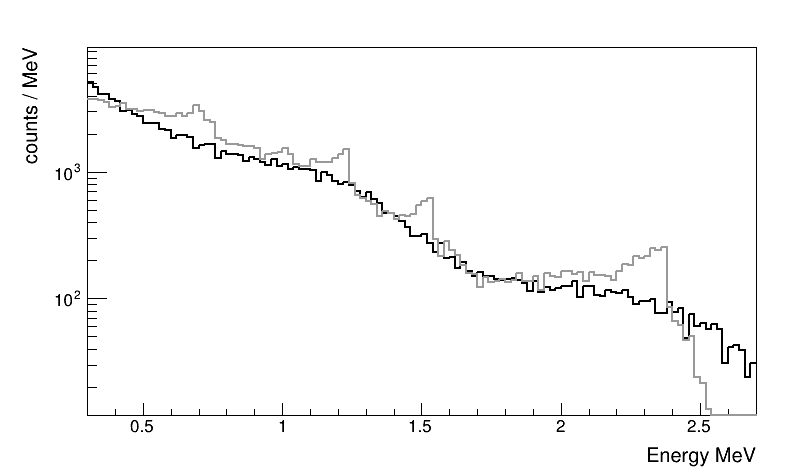

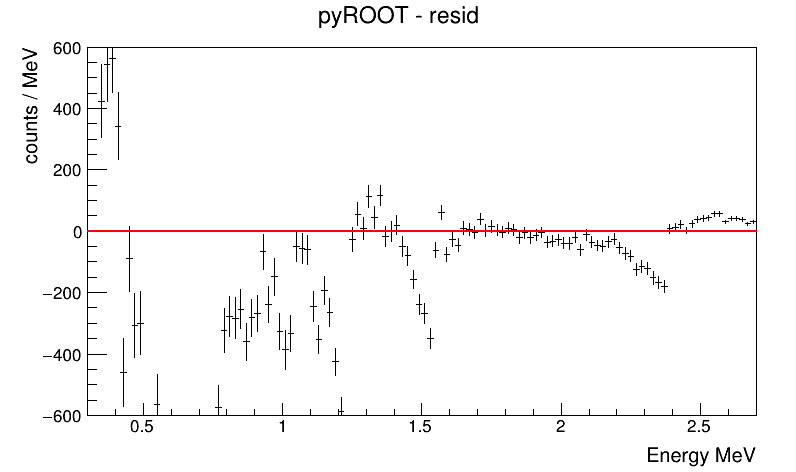

In [16]:
c1 = TCanvas('c1','',800,500)   
c1.cd()
c1.SetLogy()
h_dat.SetXTitle("Energy MeV")
h_dat.SetYTitle("counts / MeV")
h_dat.SetMarkerColor(kBlack)
h_dat.SetLineColor(kBlack)
h_dat.SetLineWidth(2)
h_dat.Draw("hist")
    
tot.SetMarkerColor(kGray+1)
tot.SetLineColor(kGray+1)
tot.SetLineWidth(2)
tot.Draw("hist same")
    
# h_sim1.SetMarkerColor(kRed+1)
# h_sim1.SetLineColor(kRed+1)
# h_sim1.SetLineWidth(1)
# h_sim1.Draw("same")
    
# h_sim2.SetMarkerColor(kBlue+1)
# h_sim2.SetLineColor(kBlue+1)
# h_sim2.SetLineWidth(1)
# h_sim2.Draw("same")
    
# h_sim3.SetMarkerColor(kGreen+1)
# h_sim3.SetLineColor(kGreen+1)
# h_sim3.SetLineWidth(1)
# h_sim3.Draw("same")
    
# h_sim4.SetMarkerColor(kYellow+1)
# h_sim4.SetLineColor(kYellow+1)
# h_sim4.SetLineWidth(1)
# h_sim4.Draw("same")
    
    
# leg = TLegend(0.75,0.65,0.95,0.9)
# leg.SetFillColor(0)
# leg.AddEntry(h_dat,"data","lp")
# leg.AddEntry(tot," ","lp")
# leg.AddEntry(h_sim1," ","lp")
# leg.AddEntry(h_sim2," ","lp")
# leg.AddEntry(h_sim3," ","lp")
# leg.AddEntry(h_sim4," ","lp")
# #leg.AddEntry(h_enr,"  raw MC","lp")
# leg.Draw()


#     h_dat.SetAxisRange(1,200,"x")
#     h_dat.SetAxisRange(1,1000*R,"y")
c1.Draw()
    
    
# add in residual plot
resid = TH1F("resid","pyROOT - resid",gbins,gmin,gmax)
c2 = TCanvas("c2","c2",0,0,800,500)
resid.Add(h_dat,tot,1,-1)
resid.SetMarkerColor(kBlack)
resid.SetLineColor(kBlack)
resid.SetLineWidth(1)
resid.SetXTitle("Energy MeV")
resid.SetYTitle("counts / MeV")
resid.SetAxisRange(-600,600,"y")
resid.Draw()

zero = TLine(gmin,0,gmax,0)
zero.SetLineColor(kRed)
zero.SetLineWidth(2)
zero.Draw()

# leg2 = TLegend(0.65,0.80,0.95,0.9)
# leg2.SetFillColor(0)
# leg2.AddEntry(resid,"data-MC residual","lp")
# #leg2.AddEntry(resid,'chi2 / ndf = '+chi2+' / '+ndf,'lp')
# leg2.Draw()
    
c2.Draw()


# see plots hack
#raw_input("[Enter] to quit\n")
input("[Enter] to quit\n")